In [1]:
import os
import tempfile

# import destvi_utils
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.model import CondSCVI, DestVI

/home/pxy/miniconda3/envs/destvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.3


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = './data/'

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

加载已经预处理好的数据集

In [4]:
st_adata_path = os.path.join(save_dir, "st_lymph_node_preprocessed.h5ad")

st_adata = sc.read(
    st_adata_path,
    backup_url="https://figshare.com/ndownloader/files/52947032",
)
st_adata

AnnData object with n_obs × n_vars = 1092 × 1888
    obs: 'in_tissue', 'array_row', 'array_col', 'batch', 'LN', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'lymph_node'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'LN_colors', 'log1p'
    obsm: 'X_pca', 'X_umap', 'location', 'modules', 'spatial'
    layers: 'counts'

In [5]:
sc_adata_path = os.path.join(save_dir, "sc_lymph_node_preprocessed.h5ad")

sc_adata = sc.read(
    sc_adata_path,
    backup_url="https://figshare.com/ndownloader/files/52947086",
)
sc_adata

AnnData object with n_obs × n_vars = 14989 × 1888
    obs: 'n_genes', 'cell_types', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pred_cell_types', 'doublet_scores', 'doublet_predictions', 'MS', 'louvain_r0.5', 'louvain_r0.7', 'louvain_r1.0', 'leiden_r0.5', 'leiden_r0.7', 'leiden_r1.0', 'DC_A', 'DC_B', 'mono_1', 'mono_2', 'louvain_sub_0.1', 'louvain_sub_0.2', 'louvain_sub_0.3', 'louvain_sub', 'louvain_sub_1', 'louvain_sub_2', 'louvain_sub_3', 'SCANVI_pred_cell_types', 'SCVI_pred_cell_types', 'broad_cell_types'
    var: 'gene_ids-0', 'genome-0', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'n_counts', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_r1.0_colors', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r0.7_colors', 'louvain_r1.0_colors', 'louvain_sub_0.2_colors', 'louvain_sub_0.3_colors', 'louvain_sub_1_colo

可视化单细胞数据中的细胞类型

In [ ]:
# sc_adata.var['genome-0'].unique

<bound method Series.unique of 1300017J02Rik    mm10
1500009L16Rik    mm10
1600010M07Rik    mm10
1700025G04Rik    mm10
1700097N02Rik    mm10
                 ... 
Zfp36            mm10
Zfp366           mm10
Zfp516           mm10
Zmynd15          mm10
Zyx              mm10
Name: genome-0, Length: 1888, dtype: category
Categories (1, object): ['mm10']>

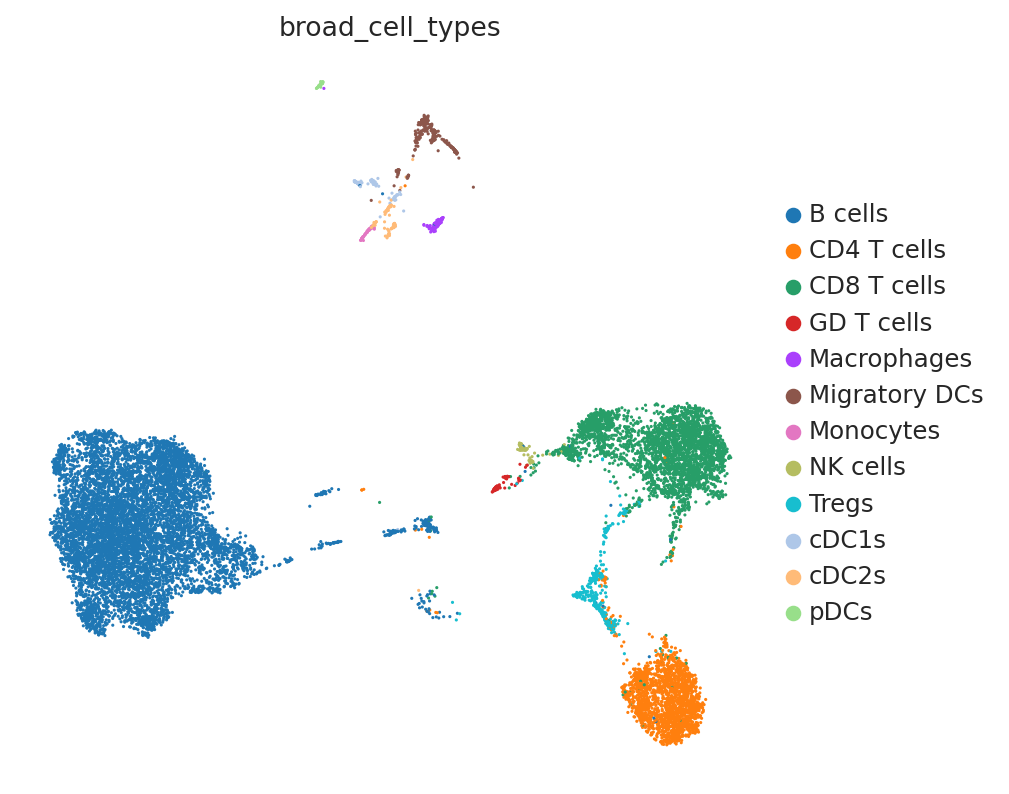

In [6]:
sc.pl.umap(sc_adata, color="broad_cell_types")

In [10]:
# 计算单细胞基因个数？
G = len(sc_adata.var_names)

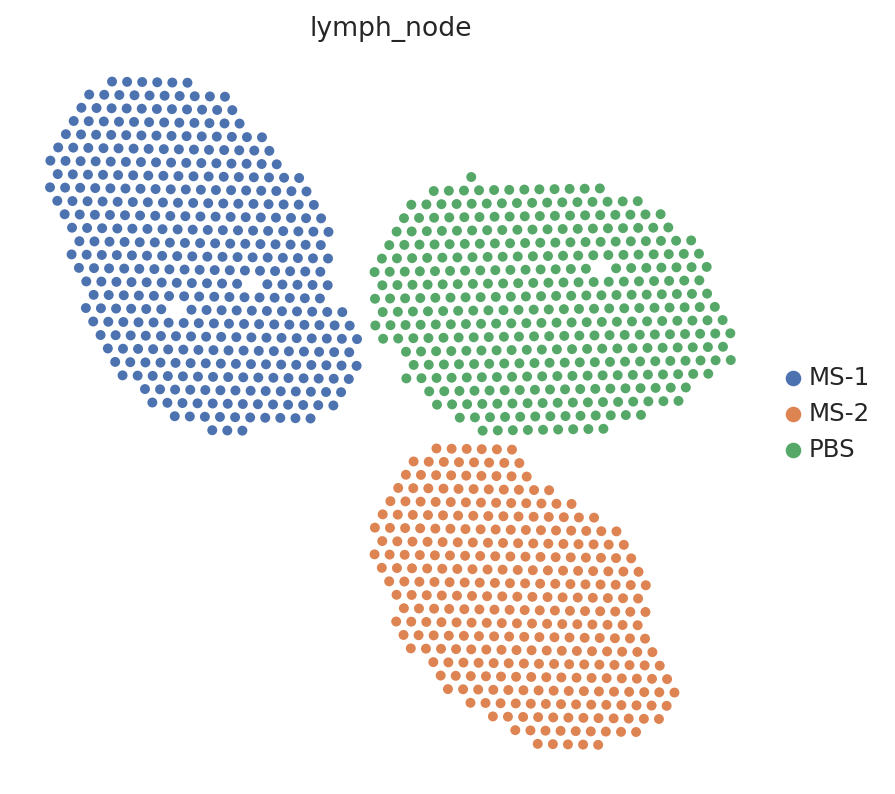

In [ ]:
# 用空间坐标展示ST数据，根据颜色区分淋巴结分组
sc.pl.embedding(st_adata, basis="spatial", color="lymph_node", s=80)

### 拟合单细胞潜在变量模型scLVM来学习细胞状态特异性基因表达模式

In [12]:
# 将单细胞数据中的原始计数数据layers['counts']、细胞类型标签broad_cell_types创建anndataManager
# manager 绑定到模型类，后续训练和推断时自动调用。
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="broad_cell_types")

第一步，用细胞类型条件变分自编码器（VAE）scLVM对数据进行嵌入。

传入包含原始计数的层（layer）和细胞类型标签（labels key）。

训练这个模型时，不会根据细胞类型的丰度对损失函数进行加权。

In [13]:
sc_model = CondSCVI(sc_adata, weight_obs=False)
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.3.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'broad_cell_types', 'layer': 'counts', 'batch_key': None}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_batch      │   1   │
│     n_cells      │ 14989 │
│     n_labels     │  12   │
│      n_vars      │ 1888  │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                         labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['broad_cell_types'] │    B cells    │          0          │
│                               │  CD4 T cells  │          1          │
│                               │  CD8 T cells  │          2          │
│                               │  GD T cells   │          3          │
│                               │  Macrophages  │          4          │
│                               │ Migratory DCs │          5          │
│                               │   Monocytes   │          6          │
│                               │   NK cells    │          7          │
│                               │     Tregs     │          8          │
│                               │     cDC1s     │          9          │
│                               │     cDC2s     │         10          │
│                               │     pDCs      │         11          │
└───────────────────────────────┴───────────────┴─────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

In [14]:
sc_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pxy/miniconda3/envs/destvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 300/300: 100%|██████████| 300/300 [07:34<00:00,  1.48s/it, v_num=1, train_loss_step=695, train_loss_epoch=802]      

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [07:34<00:00,  1.52s/it, v_num=1, train_loss_step=695, train_loss_epoch=802]


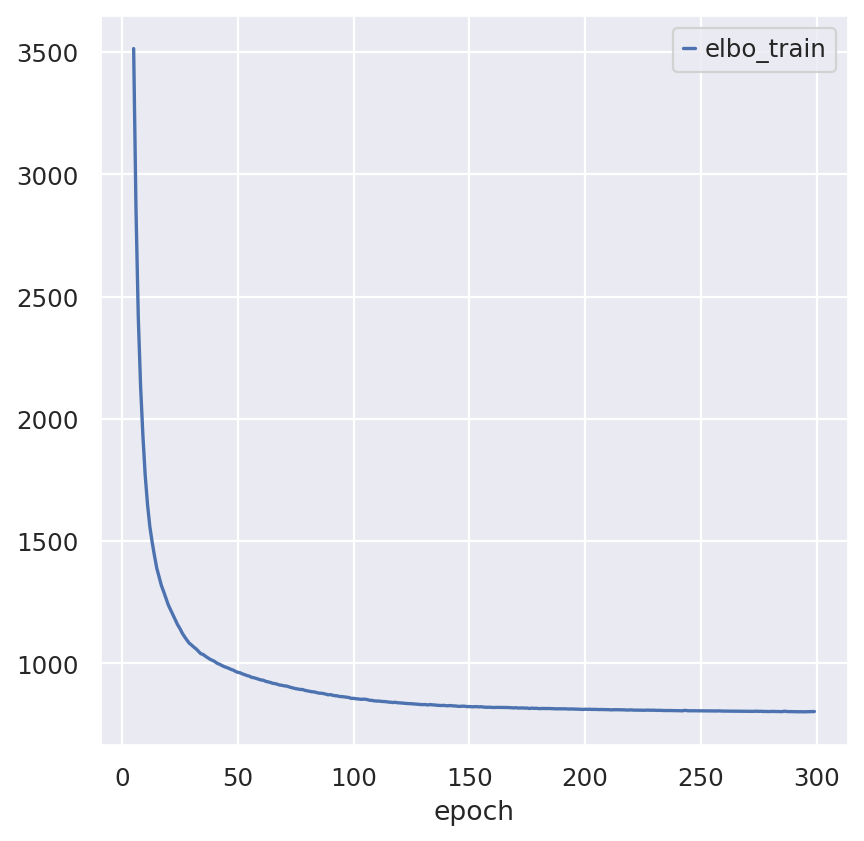

In [15]:
sc_model.history["elbo_train"].iloc[5:].plot()
plt.show()

使用stLVM进行反卷积

In [16]:
DestVI.setup_anndata(st_adata, layer="counts")

In [17]:
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.3.

Setup via `DestVI.setup_anndata` with arguments:

{'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 1092  │
│      n_vars      │ 1888  │
└──────────────────┴───────┘

              Data Registry              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃  scvi-tools Location   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │ adata.layers['counts'] │
│    ind_x     │ adata.obs['_indices']  │
└──────────────┴────────────────────────┘

In [18]:
st_model.train(max_epochs=1500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pxy/miniconda3/envs/destvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pxy/miniconda3/envs/destvi/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1500/1500: 100%|██████████| 1500/1500 [03:41<00:00,  6.88it/s, v_num=1, train_loss_step=2.01e+6, train_loss_epoch=1.96e+6]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [03:41<00:00,  6.76it/s, v_num=1, train_loss_step=2.01e+6, train_loss_epoch=1.96e+6]


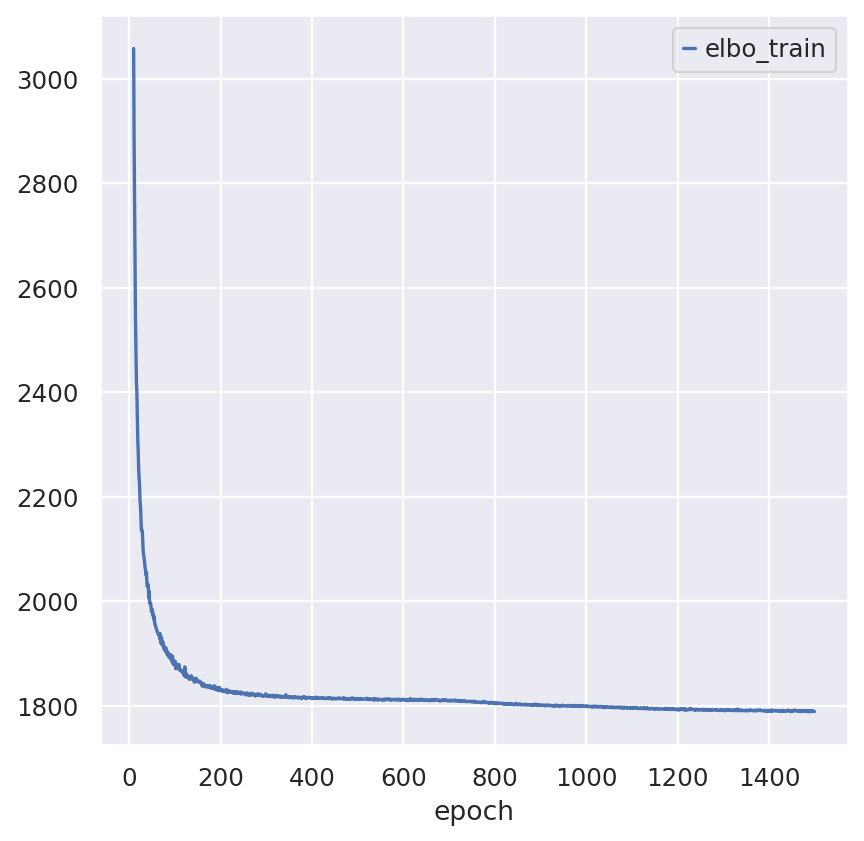

In [19]:
st_model.history["elbo_train"].iloc[10:].plot()
plt.show()

求CTP Cell type proportions细胞类型比例

提取计算出的细胞类型比例并将它们显示在空间嵌入中。

这些值是通过对 stLVM 模型中的 spot-level 参数进行归一化直接计算的。

In [20]:
st_adata.obsm["proportions"] = st_model.get_proportions()

In [21]:
st_adata.obsm["proportions"].head(5)

,B cells,CD4 T cells,CD8 T cells,GD T cells,Macrophages,Migratory DCs,Monocytes,NK cells,Tregs,cDC1s,cDC2s,pDCs
AAACCGGGTAGGTACC-1-0,0.602159,0.073813,0.015130,0.011263,0.025447,0.046628,0.016626,0.034737,0.051723,0.072086,0.033369,0.017019
AAACCTCATGAAGTTG-1-0,0.534449,0.089339,0.026622,0.015466,0.024853,0.078006,0.014631,0.033278,0.061836,0.065899,0.039898,0.015723
AAAGACTGGGCGCTTT-1-0,0.504470,0.101745,0.037338,0.015283,0.020692,0.089610,0.012039,0.039898,0.071769,0.064266,0.030505,0.012386
AAAGGGCAGCTTGAAT-1-0,0.101670,0.179238,0.183269,0.014964,0.028002,0.123387,0.018785,0.078478,0.137911,0.108076,0.014283,0.011937
AAAGTCGACCCTCAGT-1-0,0.723996,0.033568,0.002659,0.008003,0.021040,0.050332,0.009068,0.015554,0.020006,0.075493,0.031791,0.008491


In [22]:
ct_list = ["B cells", "CD8 T cells", "Monocytes"]
for ct in ct_list:
    data = st_adata.obsm["proportions"][ct].values
    st_adata.obs[ct] = np.clip(data, 0, np.quantile(data, 0.99))

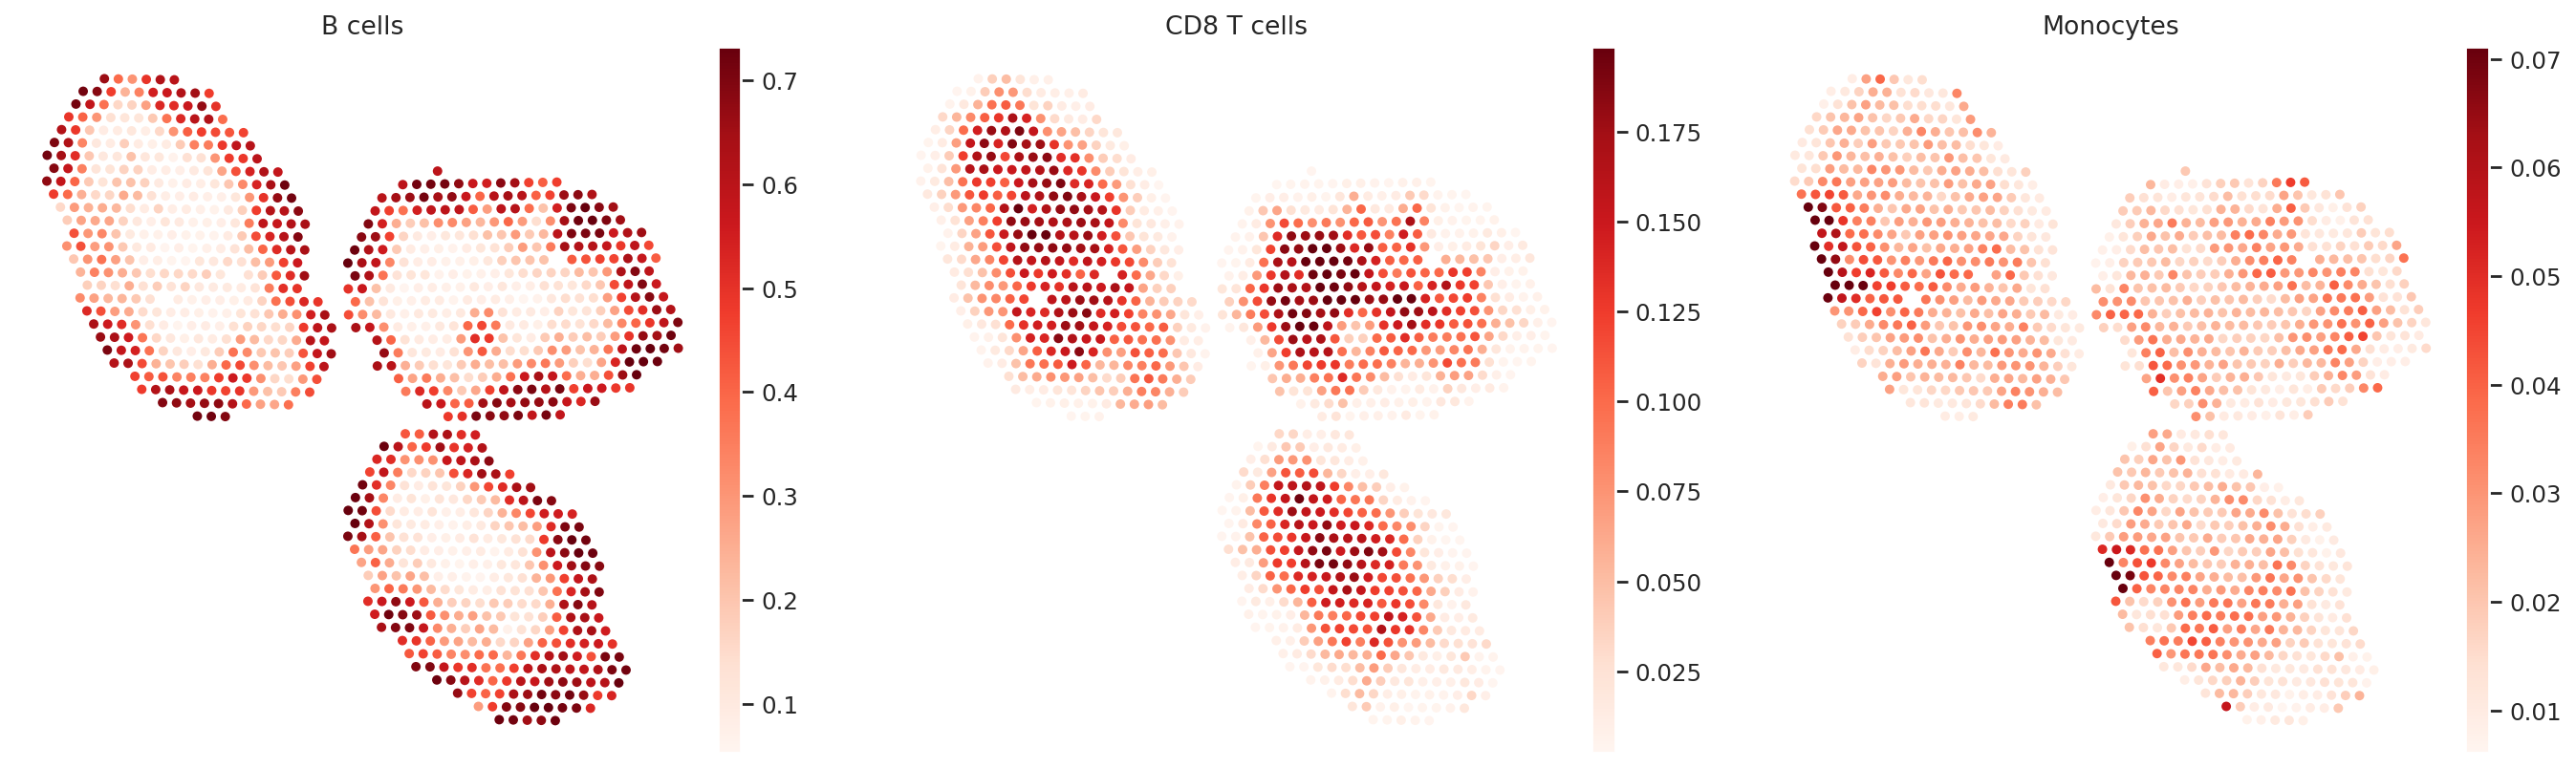

In [23]:
sc.pl.embedding(st_adata, basis="spatial", color=ct_list, cmap="Reds", s=80)

细胞内类型信息

In [24]:
# more globally, the values of the gamma are all summarized in this dictionary of data frames
for ct, g in st_model.get_gamma().items():
    st_adata.obsm[f"{ct}_gamma"] = g

In [29]:
# len(st_adata.obsm["B cells_gamma"])
# st_adata.obsm["B cells_gamma"].columns
st_adata.obsm["B cells_gamma"].shape

(1092, 5)

In [ ]:
st_adata.obsm["B cells_gamma"].head(5)

,0,1,2,3,4
AAACCGGGTAGGTACC-1-0,-0.555524,0.131141,0.150046,-0.274882,0.594412
AAACCTCATGAAGTTG-1-0,-1.309952,-1.037888,0.392673,-0.838580,0.308356
AAAGACTGGGCGCTTT-1-0,-1.766793,-0.617519,0.381506,-0.564547,-0.223396
AAAGGGCAGCTTGAAT-1-0,-0.498066,-0.012978,0.292812,0.239748,-0.496341
AAAGTCGACCCTCAGT-1-0,0.160855,0.087786,0.046619,-0.982064,0.692606


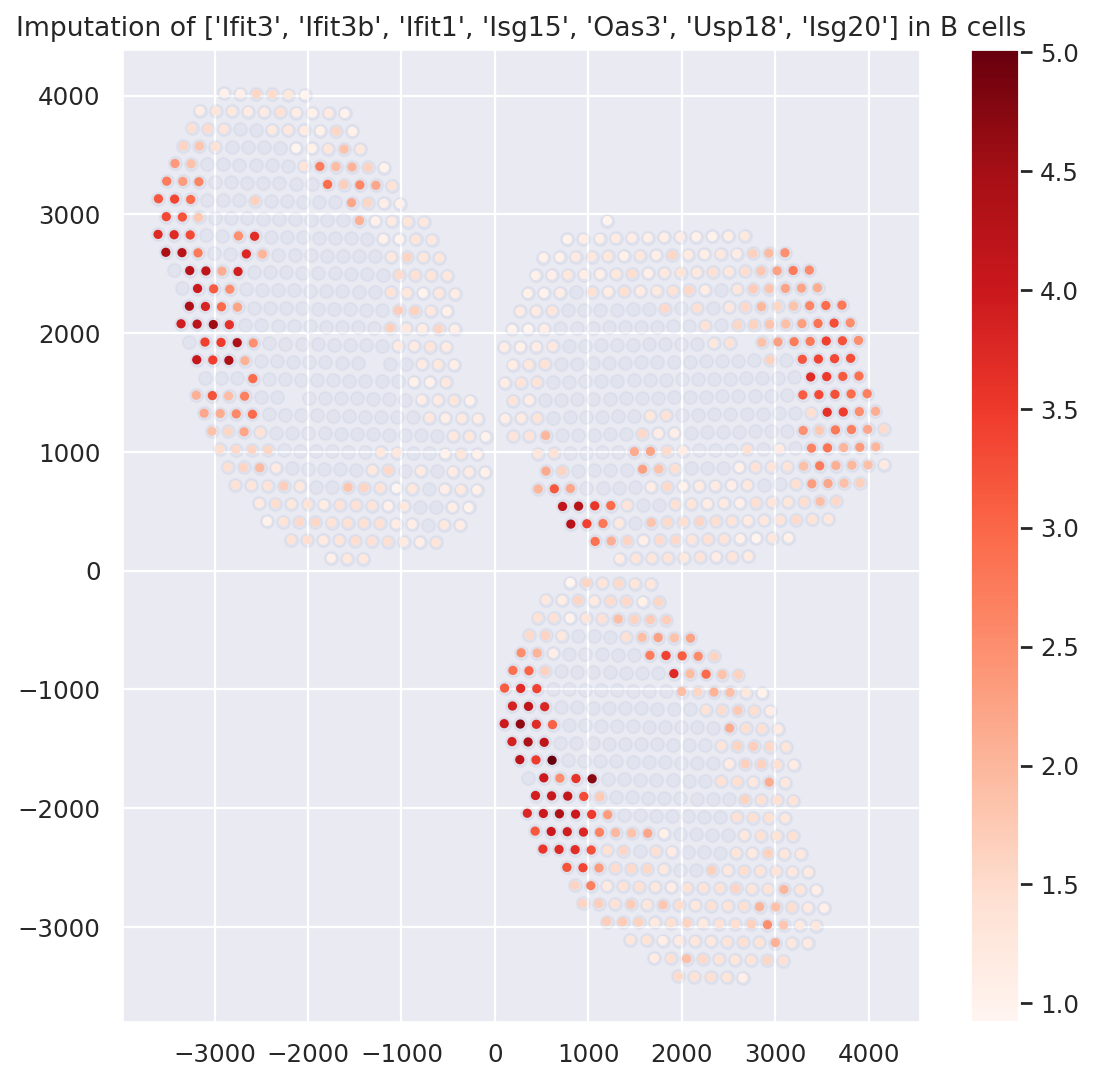

In [26]:
plt.figure(figsize=(8, 8))

ct_name = "B cells"
gene_name = ["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"]

# we must filter spots with low abundance (consult the paper for an automatic procedure)
indices = np.where(st_adata.obsm["proportions"][ct_name].values > 0.2)[0]

# impute genes and combine them
specific_expression = np.sum(st_model.get_scale_for_ct(ct_name, indices=indices)[gene_name], 1)
specific_expression = np.log(1 + 1e4 * specific_expression)

# plot (i) background (ii) g
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(
    st_adata.obsm["location"][indices][:, 0],
    st_adata.obsm["location"][indices][:, 1],
    c=specific_expression,
    s=10,
    cmap="Reds",
)
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {ct_name}")
plt.show()